# FitBit Days: A NN to classify days

The goal is to use my personal data to classify ‘office days’ vs ‘recreation days’. Everyone has a different activity level, and goal was to build a model to categorize the days in and out of the office. If I can learn different categories of days I have, it can better recommend actions for me to be healthier.

### Why?
Often I find myself working weekends, when I should be recharging my mental batteries. Can my FitBit tell me when that is happening?

Let’s take an example: How should my tracker respond if I am working on a cool TensorFlow project and am at the office though a weekend? If my tracker can identify this, later in the month it can recommend to me to be more active because I did not have my normal activity levels earlier in the month. For someone like me, (who can be a bit obsessive about a project) that would be extremely helpful.

### How?

As a proxy for ‘office days’ I will look at data from weekdays, the fraction of holidays should be small in this sample. As a proxy for ‘recreation days’ I will use weekends, my personal weekend activity will vary greatly but I hope will be distinct.

#### How to get your data

Really easy! Here is a link with the instructions:

[Download Your Fitbit Data](https://help.fitbit.com/articles/en_US/Help_article/1133)

### Intuition

My intuition was that my weekend days would have more total steps on average as I run errands. However, my office days would be more consistent because weekend activities vary greatly. I also think I sleep longer on weekends than on weekdays. Those weekend days may have also higher fraction of time in sedentary state, while I relax and do some mental reset.

This is completely anecdotal, but can it be confirmed with actual data?

## Deliverable

Below I go into the details of what is actually done, but what is the deliverable for this project?

Two parts:

1. [Python Module](https://github.com/chmartin/FitBit-Analysis/blob/master/FitBit_Weeday_Classifier.py): Allows user to fit the NN to their own activity to make 'office day' vs 'recreation day' classification themselves
2. [Tableau Dashboard](https://public.tableau.com/profile/christopher.martin1729#!/vizhome/FitBit-Analysis/Dashboard1): Take the output of the python module to make a nice visualization

## The Details

#### 'standard' Imports

In [3]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Read Steps json

(Not rerun, due to time)

In [4]:
df_steps = pd.DataFrame()
for file in glob.glob("./ChrisMartin/user-site-export/steps-*.json"):
    #print(file)
    df_file = pd.read_json(file,orient='records')
    df_steps = df_steps.append(df_file)

#### Basic Data Exploration

In [5]:
df_steps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1894273 entries, 0 to 41983
Data columns (total 2 columns):
dateTime    datetime64[ns]
value       int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 43.4 MB


In [6]:
df_steps.head()

,dateTime,value
0,2016-09-15 22:00:00,0
1,2016-09-15 22:01:00,0
2,2016-09-15 22:02:00,0
3,2016-09-15 22:03:00,0
4,2016-09-15 22:04:00,0


#### Basic plot of steps v Time of day

Time of day where activity starts and stops could be extremely powerful.

(Not rerun, for time)

In [7]:
df_steps = df_steps.set_index('dateTime')
first_day = (df_steps.index.min()).date() # Could be usefull later
last_day = (df_steps.index.max()).date() # Could be usefull later

Text(0.5, 1.0, 'Steps v. Time')

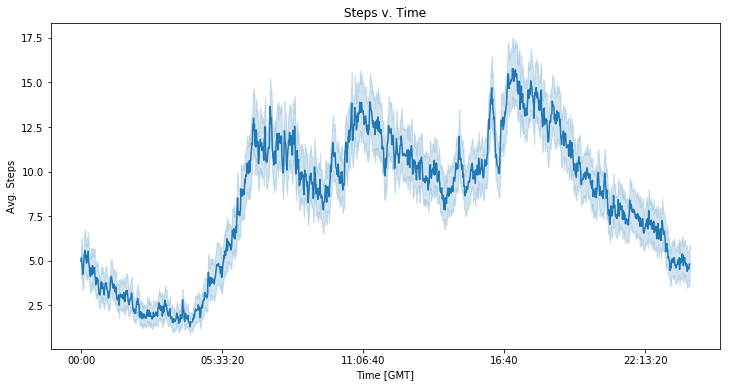

In [8]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df_steps.index.time,y='value',data=df_steps)
plt.xlabel("Time [GMT]")
plt.ylabel("Avg. Steps")
plt.title("Steps v. Time")

At this point, I remembered that this dataset will have my time in Europe and USA all mixed together (non-trivial fraction). While, the records are kept in GMT.

This means to use the time information I should translate things to local time. This would require going back through travel history. (Probably not worth the time.)

### Daily Step Sum

To separate active 'weekend days' from sedentary 'office days'

In [9]:
df_day_sum = df_steps.groupby(df_steps.index.to_period('d')).cumsum()

Text(0.5, 1.0, 'Accumulated Steps v. Time')

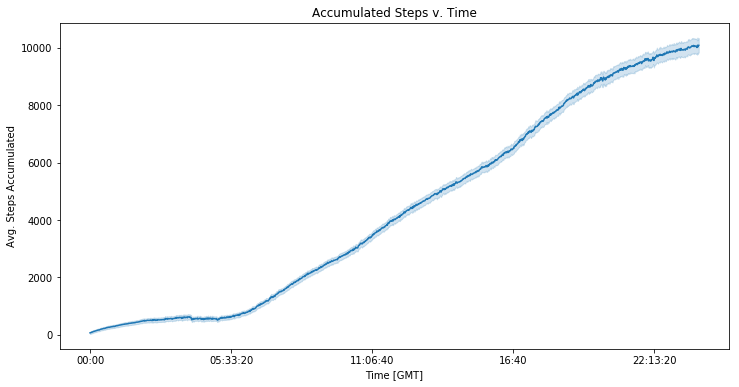

In [10]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df_day_sum.index.time,y='value',data=df_day_sum)
plt.xlabel("Time [GMT]")
plt.ylabel("Avg. Steps Accumulated")
plt.title("Accumulated Steps v. Time")

How many days does the dataset cover?

In [12]:
sum_steps_easy = pd.DataFrame(df_steps.groupby(df_steps.index.date).sum())
sum_steps_easy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1620 entries, 2014-08-29 to 2019-03-26
Data columns (total 1 columns):
value    1620 non-null int64
dtypes: int64(1)
memory usage: 25.3+ KB


#### 1620 Days

Text(0.5, 1.0, 'Daily Steps Accumulated')

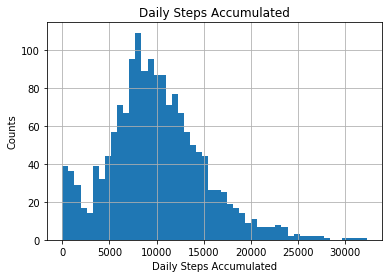

In [52]:
sum_steps_easy.hist(bins=50)
plt.xlabel("Daily Steps Accumulated")
plt.ylabel("Counts")
plt.title("Daily Steps Accumulated")

#### First quality cut, a day needs at least 1500 steps

In [53]:
sum_steps_easy_v2 = sum_steps_easy[sum_steps_easy['value'] > 1500]

/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Daily Steps Accumulated')

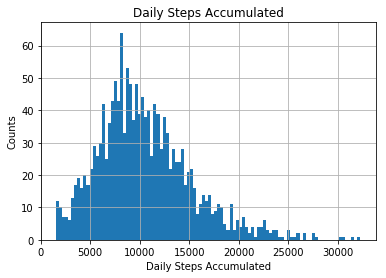

In [54]:
sum_steps_easy_v2['sum'] = sum_steps_easy_v2['value']
sum_steps_easy_v2 = sum_steps_easy_v2.drop('value',axis=1)
sum_steps_easy_v2.hist(bins=100)
plt.xlabel("Daily Steps Accumulated")
plt.ylabel("Counts")
plt.title("Daily Steps Accumulated")

#### Strong historical trend?

Text(0.5, 1.0, 'Steps Accumulated each Day')

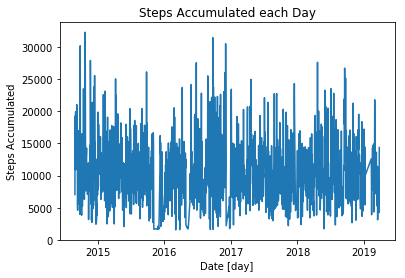

In [55]:
sns.lineplot(x=sum_steps_easy_v2.index,y='sum',data=sum_steps_easy_v2)
plt.xlabel("Date [day]")
plt.ylabel("Steps Accumulated")
plt.title("Steps Accumulated each Day")

#### Missing Dates

In [56]:
missing_dates = pd.date_range(start = '2014-08-29', end = '2019-03-26' ).difference(sum_steps_easy_v2.index)

In [57]:
print(missing_dates)

DatetimeIndex(['2014-10-19', '2015-03-30', '2015-08-06', '2015-08-07',
               '2015-08-08', '2015-08-09', '2015-11-06', '2015-11-07',
               '2015-11-08', '2015-11-09',
               ...
               '2019-01-31', '2019-02-01', '2019-02-02', '2019-02-03',
               '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07',
               '2019-02-08', '2019-02-09'],
              dtype='datetime64[ns]', length=140, freq=None)


Convert date type

In [58]:
sum_steps_easy_v2['date_np'] = sum_steps_easy_v2.index.to_series().apply(lambda x: np.datetime64(str(x)))

In [59]:
sum_steps_easy_v2.head()


,sum,date_np
2014-08-29,7056,2014-08-29
2014-08-30,19267,2014-08-30
2014-08-31,12454,2014-08-31
2014-09-01,10891,2014-09-01
2014-09-02,19943,2014-09-02


In [60]:
sum_steps_easy_v2 = sum_steps_easy_v2.reset_index()

In [61]:
sum_steps_easy_v2 = sum_steps_easy_v2.drop('index',axis=1)

In [62]:
sum_steps_easy_v2.head()

,sum,date_np
0,7056,2014-08-29
1,19267,2014-08-30
2,12454,2014-08-31
3,10891,2014-09-01
4,19943,2014-09-02


#### Get True Day of Week / Weekend

In [63]:
sum_steps_easy_v2['day_of_week'] = sum_steps_easy_v2['date_np'].dt.dayofweek

In [64]:
sum_steps_easy_v2['weekend'] = sum_steps_easy_v2['day_of_week'].apply(lambda x: x > 4)
sum_steps_easy_v2 = sum_steps_easy_v2.drop('day_of_week',axis=1)

In [65]:
sum_steps_easy_v2.head()

,sum,date_np,weekend
0,7056,2014-08-29,False
1,19267,2014-08-30,True
2,12454,2014-08-31,True
3,10891,2014-09-01,False
4,19943,2014-09-02,False


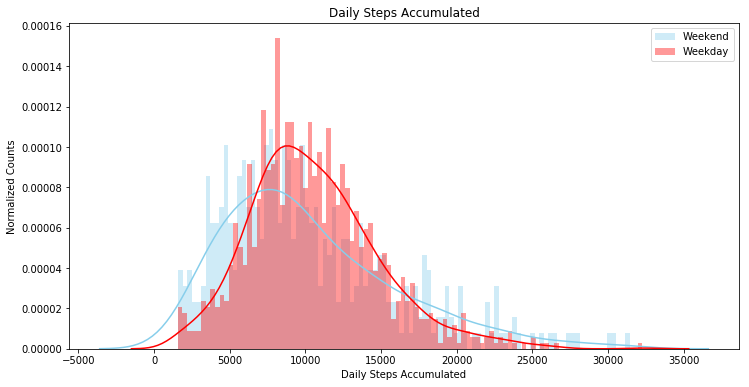

In [75]:
axis = plt.figure(figsize=(12,6))
sns.distplot( sum_steps_easy_v2.loc[sum_steps_easy_v2['weekend'] == True,'sum'] , color="skyblue", label="Weekend",bins=100)
sns.distplot( sum_steps_easy_v2.loc[sum_steps_easy_v2['weekend'] == False,'sum'] , color="red", label="Weekday",bins=100)
plt.legend()
plt.xlabel("Daily Steps Accumulated")
plt.ylabel("Normalized Counts")
plt.title("Daily Steps Accumulated")
plt.show()

## Repeat with sleep and activity classification data

(Nothing special, simple cleaning and exploration.)

In [137]:
df_sleep = pd.DataFrame()
for file in glob.glob("./ChrisMartin/user-site-export/sleep-*.json"):
    #print(file)
    df_file = pd.read_json(file,orient='records')
    df_sleep = df_sleep.append(df_file)

In [138]:
df_sleep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1583 entries, 0 to 34
Data columns (total 14 columns):
dateOfSleep            1583 non-null object
duration               1583 non-null int64
efficiency             1583 non-null int64
endTime                1583 non-null object
infoCode               1583 non-null int64
levels                 1583 non-null object
logId                  1583 non-null int64
minutesAfterWakeup     1583 non-null int64
minutesAsleep          1583 non-null int64
minutesAwake           1583 non-null int64
minutesToFallAsleep    1583 non-null int64
startTime              1583 non-null object
timeInBed              1583 non-null int64
type                   1583 non-null object
dtypes: int64(9), object(5)
memory usage: 185.5+ KB


In [139]:
df_sleep['date_np'] = df_sleep['dateOfSleep'].apply(lambda x: np.datetime64(str(x)))

In [140]:
sum_sleep = df_sleep.groupby(df_sleep['date_np']).sum()

In [141]:
sum_sleep.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1355 entries, 2014-08-30 to 2019-03-26
Data columns (total 9 columns):
duration               1355 non-null int64
efficiency             1355 non-null int64
infoCode               1355 non-null int64
logId                  1355 non-null int64
minutesAfterWakeup     1355 non-null int64
minutesAsleep          1355 non-null int64
minutesAwake           1355 non-null int64
minutesToFallAsleep    1355 non-null int64
timeInBed              1355 non-null int64
dtypes: int64(9)
memory usage: 105.9 KB


In [142]:
sum_sleep = sum_sleep.reset_index()
sum_sleep['day_of_week'] = sum_sleep['date_np'].dt.dayofweek
sum_sleep['weekend'] = sum_sleep['day_of_week'].apply(lambda x: x > 4)

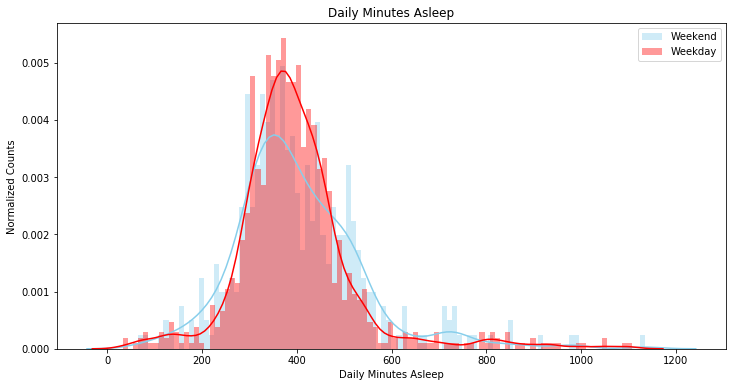

In [143]:
axis = plt.figure(figsize=(12,6))
sns.distplot( sum_sleep.loc[sum_sleep['weekend'] == True,'minutesAsleep'] , color="skyblue", label="Weekend",bins=100)
sns.distplot( sum_sleep.loc[sum_sleep['weekend'] == False,'minutesAsleep'] , color="red", label="Weekday",bins=100)
plt.legend()
plt.xlabel("Daily Minutes Asleep")
plt.ylabel("Normalized Counts")
plt.title("Daily Minutes Asleep")
plt.show()

### Cut away days without at least 200 minutes asleep.

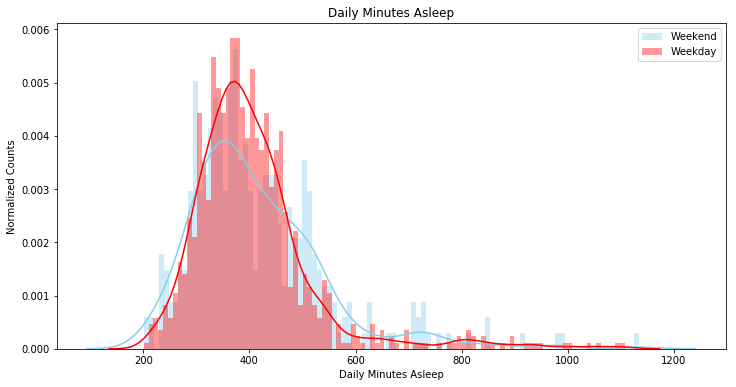

In [144]:
sum_sleep = sum_sleep[sum_sleep['minutesAsleep'] > 200]
axis = plt.figure(figsize=(12,6))
sns.distplot( sum_sleep.loc[sum_sleep['weekend'] == True,'minutesAsleep'] , color="skyblue", label="Weekend",bins=100)
sns.distplot( sum_sleep.loc[sum_sleep['weekend'] == False,'minutesAsleep'] , color="red", label="Weekday",bins=100)
plt.legend()
plt.xlabel("Daily Minutes Asleep")
plt.ylabel("Normalized Counts")
plt.title("Daily Minutes Asleep")
plt.show()

In [145]:
sum_sleep = sum_sleep.drop(['infoCode','logId','day_of_week'],axis=1)

/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


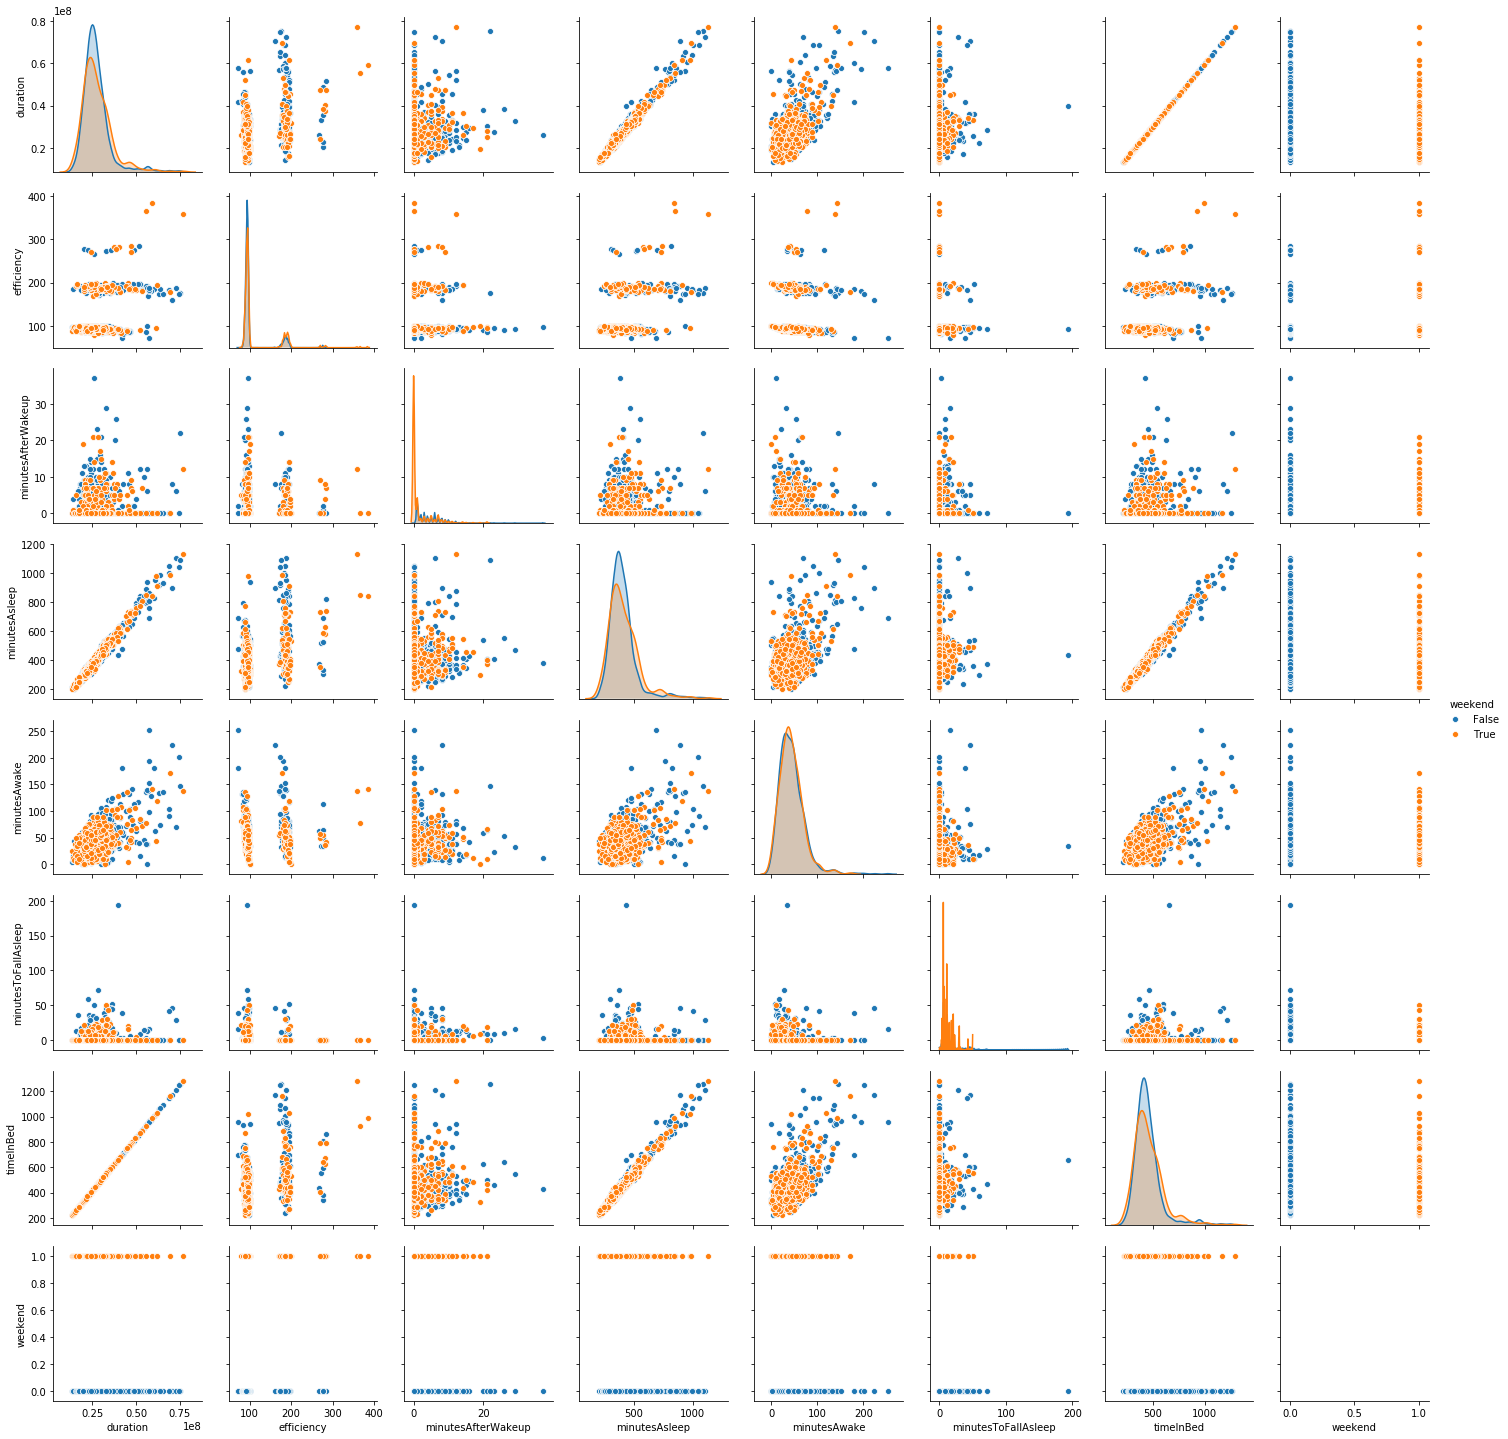

In [146]:
sns.pairplot(sum_sleep,hue='weekend')

#### Strong correlations: 'minutesAsleep', 'duration', and 'timeInBed'. I choose to use 'minutesAsleep' and drop others.

Drop 'efficiency','minutesToFallAsleep',and 'minutesAfterWakeup' because they don't have good distributions

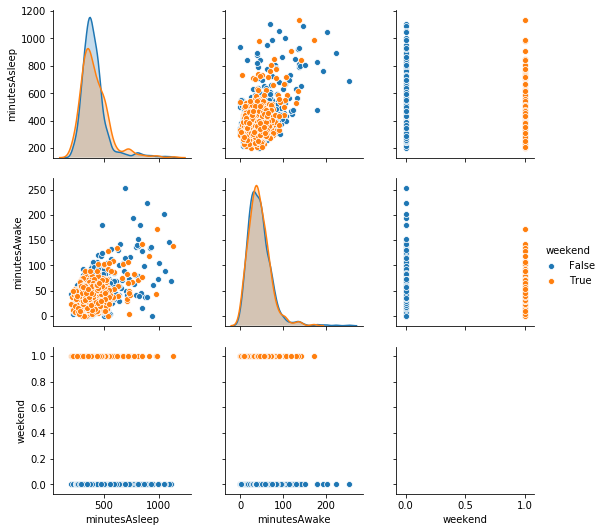

In [147]:
sum_sleep = sum_sleep.drop(['timeInBed','duration','efficiency','minutesToFallAsleep','minutesAfterWakeup'],axis=1)
sns.pairplot(sum_sleep,hue='weekend')

### Merge with steps

In [148]:
Merged = sum_steps_easy_v2.merge(sum_sleep,on=['weekend','date_np'],how='inner')

In [149]:
#sns.pairplot(Merged,hue='weekend')

#### Load Sedentary Minutes

In [150]:
df_sed = pd.DataFrame()
for file in glob.glob("./ChrisMartin/user-site-export/sedentary_minutes-*.json"):
    #print(file)
    df_file = pd.read_json(file,orient='records')
    df_sed = df_sed.append(df_file)
df_sed.info()
print("Unique dates: ",df_sed['dateTime'].nunique())
df_sed['day_of_week'] = df_sed['dateTime'].dt.dayofweek
df_sed['weekend'] = df_sed['day_of_week'].apply(lambda x: x > 4)
#sns.pairplot(df_sed,hue='weekend')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1680 entries, 0 to 29
Data columns (total 2 columns):
dateTime    1680 non-null datetime64[ns]
value       1680 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 39.4 KB
Unique dates:  1680


#### Very Active Minutes

In [151]:
df_va = pd.DataFrame()
for file in glob.glob("./ChrisMartin/user-site-export/very_active_minutes-*.json"):
    #print(file)
    df_file = pd.read_json(file,orient='records')
    df_va = df_va.append(df_file)
df_va.info()
print("Unique dates: ",df_va['dateTime'].nunique())
df_va['day_of_week'] = df_va['dateTime'].dt.dayofweek
df_va['weekend'] = df_va['day_of_week'].apply(lambda x: x > 4)
#sns.pairplot(df_va,hue='weekend')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1680 entries, 0 to 29
Data columns (total 2 columns):
dateTime    1680 non-null datetime64[ns]
value       1680 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 39.4 KB
Unique dates:  1680


#### Lightly Active Minutes

In [152]:
df_la = pd.DataFrame()
for file in glob.glob("./ChrisMartin/user-site-export/lightly_active_minutes-*.json"):
    #print(file)
    df_file = pd.read_json(file,orient='records')
    df_la = df_la.append(df_file)
df_la.info()
print("Unique dates: ",df_la['dateTime'].nunique())
df_la['day_of_week'] = df_la['dateTime'].dt.dayofweek
df_la['weekend'] = df_la['day_of_week'].apply(lambda x: x > 4)
#sns.pairplot(df_la,hue='weekend')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1680 entries, 0 to 29
Data columns (total 2 columns):
dateTime    1680 non-null datetime64[ns]
value       1680 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 39.4 KB
Unique dates:  1680


#### Moderately Active Minutes

In [153]:
df_ma = pd.DataFrame()
for file in glob.glob("./ChrisMartin/user-site-export/moderately_active_minutes-*.json"):
    #print(file)
    df_file = pd.read_json(file,orient='records')
    df_ma = df_ma.append(df_file)
df_ma.info()
print("Unique dates: ",df_ma['dateTime'].nunique())
df_ma['day_of_week'] = df_ma['dateTime'].dt.dayofweek
df_ma['weekend'] = df_ma['day_of_week'].apply(lambda x: x > 4)
#sns.pairplot(df_ma,hue='weekend')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1680 entries, 0 to 29
Data columns (total 2 columns):
dateTime    1680 non-null datetime64[ns]
value       1680 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 39.4 KB
Unique dates:  1680


#### Merge and clean

/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda2/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


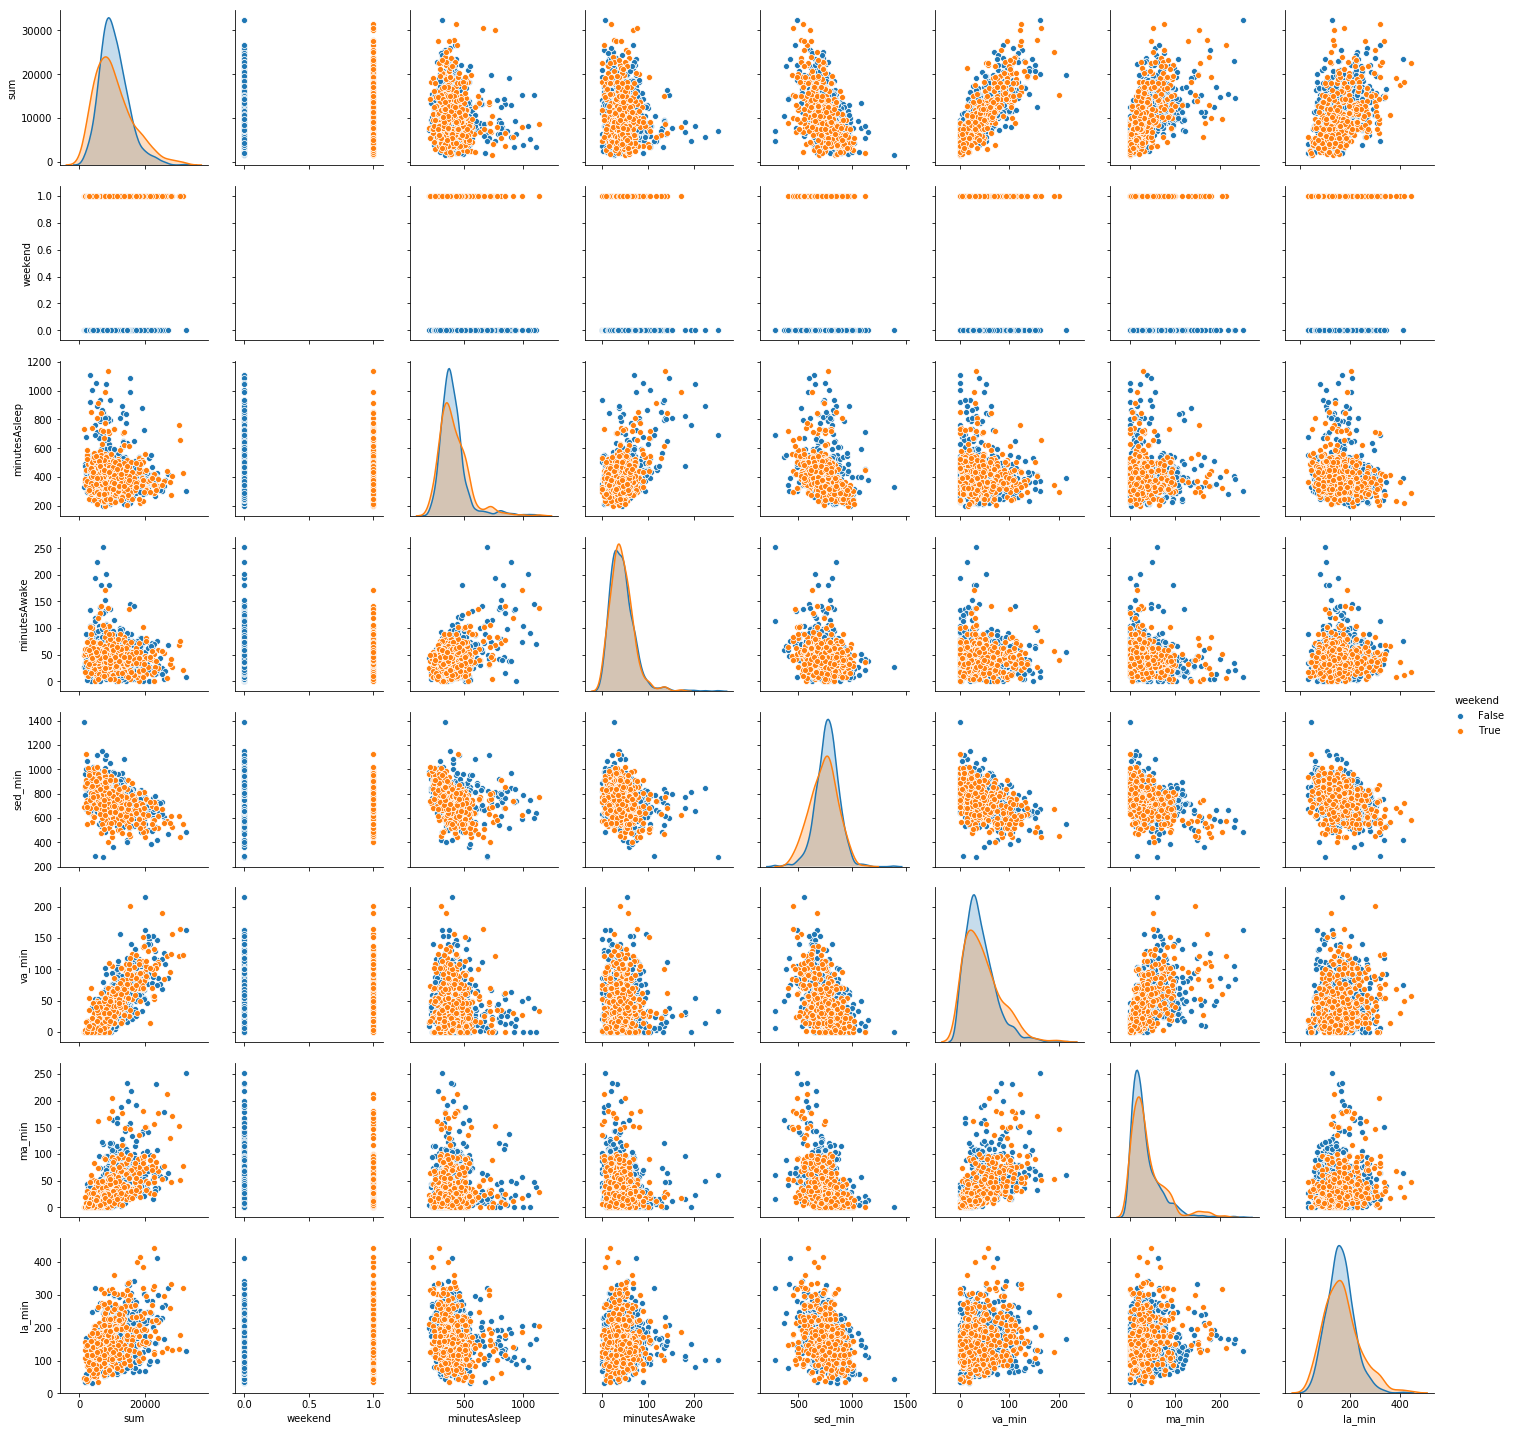

In [154]:
df_sed['sed_min'] = df_sed['value']
df_sed['date_np'] = df_sed['dateTime']
df_sed = df_sed.drop(['value','day_of_week','dateTime'],axis=1)
df_va['va_min'] = df_va['value']
df_va['date_np'] = df_va['dateTime']
df_va = df_va.drop(['value','day_of_week','dateTime'],axis=1)
df_ma['ma_min'] = df_ma['value']
df_ma['date_np'] = df_ma['dateTime']
df_ma = df_ma.drop(['value','day_of_week','dateTime'],axis=1)
df_la['la_min'] = df_la['value']
df_la['date_np'] = df_la['dateTime']
df_la = df_la.drop(['value','day_of_week','dateTime'],axis=1)
Merged = Merged.merge(df_sed,on=['weekend','date_np'],how='inner')
Merged = Merged.merge(df_va,on=['weekend','date_np'],how='inner')
Merged = Merged.merge(df_ma,on=['weekend','date_np'],how='inner')
Merged = Merged.merge(df_la,on=['weekend','date_np'],how='inner')
sns.pairplot(Merged,hue='weekend')

## Final Number of Days: 1275

In [155]:
Merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1275 entries, 0 to 1274
Data columns (total 9 columns):
sum              1275 non-null int64
date_np          1275 non-null datetime64[ns]
weekend          1275 non-null bool
minutesAsleep    1275 non-null int64
minutesAwake     1275 non-null int64
sed_min          1275 non-null int64
va_min           1275 non-null int64
ma_min           1275 non-null int64
la_min           1275 non-null int64
dtypes: bool(1), datetime64[ns](1), int64(7)
memory usage: 130.9 KB


## Final Number of Weekend Days: 351

In [156]:
Merged[Merged.weekend].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351 entries, 0 to 1272
Data columns (total 9 columns):
sum              351 non-null int64
date_np          351 non-null datetime64[ns]
weekend          351 non-null bool
minutesAsleep    351 non-null int64
minutesAwake     351 non-null int64
sed_min          351 non-null int64
va_min           351 non-null int64
ma_min           351 non-null int64
la_min           351 non-null int64
dtypes: bool(1), datetime64[ns](1), int64(7)
memory usage: 25.0 KB


### Load Tensorflow, and other ML models

In [160]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import QuantileTransformer

### Split dataset into train and test. Then do Standardization using the QuantileTransformer

#### Without Standardization: NN has about a 50% classification accuracy

In [189]:
X_train, X_test, y_train, y_test = train_test_split(Merged.drop(['weekend','date_np'],axis=1), Merged['weekend'].astype(int), test_size=0.2, stratify=Merged['weekend'].astype(int),random_state=42)
#scaler = StandardScaler()
rng = np.random.RandomState(304)
scaler = QuantileTransformer(output_distribution='normal',random_state=rng)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Number of days in training set: 1020

In [190]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1020 entries, 808 to 1151
Data columns (total 7 columns):
sum              1020 non-null int64
minutesAsleep    1020 non-null int64
minutesAwake     1020 non-null int64
sed_min          1020 non-null int64
va_min           1020 non-null int64
ma_min           1020 non-null int64
la_min           1020 non-null int64
dtypes: int64(7)
memory usage: 63.8 KB


### How does our data look after QuantileTransformation

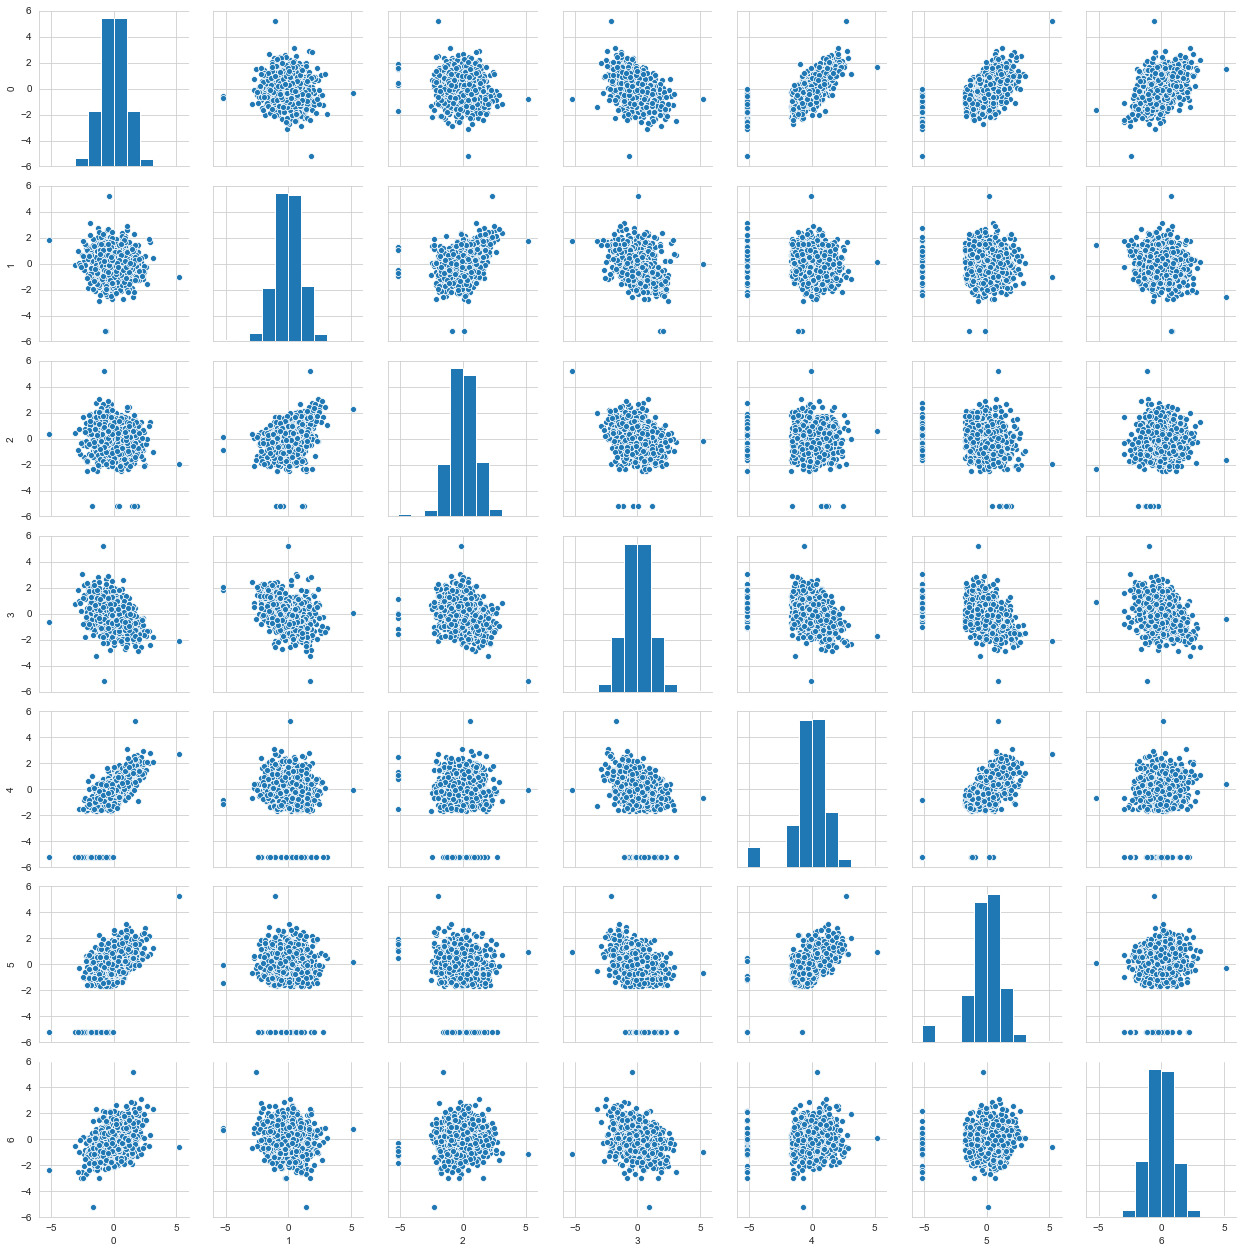

In [191]:
sns.pairplot(pd.DataFrame(X_train_scaled))

#### Fraction of Weekend days in training set

In [192]:
sum(y_train)/len(y_train)

0.2754901960784314

#### Fraction of Weekend days in full dataset

In [193]:
len(Merged[Merged.weekend])/len(Merged)

0.2752941176470588

#### Dimension of features

In [194]:
len(X_train_scaled[0])

7

## Training and Testing the NN

Strategy based on this blog:
https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

### Baseline model
1. Single fully connected hidden layer with the same number of neurons as input features (7)
2. RELU activation on hidden layer (tried a few others), 'Sigmoid' on output layer (Ideal because we want 0 or 1 output)
3. 'Normal' Initialization for both layers
4. Define 'Binary Cross Entropy' as loss function −((y)log(p)+(1−y)log(1−p))
5. Use 'ADAM' Optimizer "exponential moving average of the gradient and the squared gradient"
6. 'Accuracy' as evaluation metric

### Smaller model
Reduce to half the number of neurons

### Larger model
Add second hidden layer with half the number of neurons as first hidden layer

### Default plus
In this model I played around with different numbers of layers, neurons, initializations, and activation functions.

In [195]:
# baseline model
def create_baseline():
    # create model
    model = keras.Sequential()
    model.add(layers.Dense(7, input_dim=7, kernel_initializer='normal', activation='relu'))
    model.add(layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_smaller():
    # create model
    model = keras.Sequential()
    model.add(layers.Dense(4, input_dim=7, kernel_initializer='normal', activation='relu'))
    model.add(layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_larger():
    # create model
    model = keras.Sequential()
    model.add(layers.Dense(7, input_dim=7, kernel_initializer='normal', activation='relu'))
    model.add(layers.Dense(4, kernel_initializer='normal', activation='relu'))
    model.add(layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_default_plus():
    # create model
    model = keras.Sequential()
    model.add(layers.Dense(7, input_dim=7, kernel_initializer='uniform', activation='sigmoid'))
    model.add(layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### First, check that we have enough epochs, visualize the training history, and first pass at classification report and confusion matrix

#### Use an EarlyStopping (from Tensorflow examples), and 20% of Training data used for Validation

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________

....................................................................................................
......................

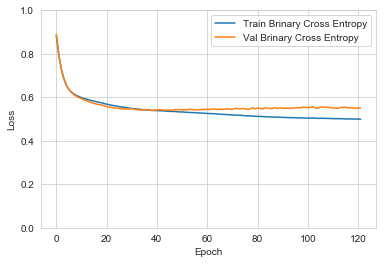

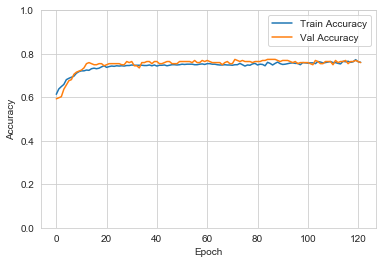

              precision    recall  f1-score   support

           0       0.88      0.75      0.81       216
           1       0.24      0.44      0.31        39

   micro avg       0.71      0.71      0.71       255
   macro avg       0.56      0.60      0.56       255
weighted avg       0.78      0.71      0.74       255

[[163  53]
 [ 22  17]]


In [196]:
# The patience parameter is the amount of epochs to check for improvement

def plot_history(history):
  sns.set_style("whitegrid")
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Brinary Cross Entropy')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Brinary Cross Entropy')
  plt.ylim([0,1])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['acc'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_acc'],
           label = 'Val Accuracy')
  plt.ylim([0,1])
  plt.legend()
  plt.show()
    
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=50)

model = create_baseline()
model.summary()

history = model.fit(X_train_scaled, y_train, epochs=EPOCHS*10,
                    validation_split = 0.2, verbose=0, batch_size=5, callbacks=[early_stop, PrintDot()])

plot_history(history)

pred = model.predict(X_test_scaled)
print(classification_report((pred > .5).astype(int),y_test))
print(confusion_matrix((pred > .5).astype(int),y_test))

### Repeat with smaller

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 4)                 32        
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 5         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________

.............................................................................

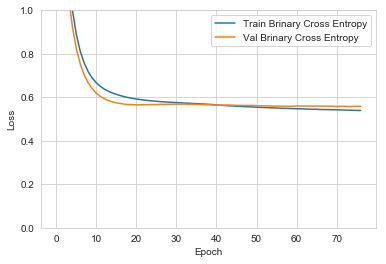

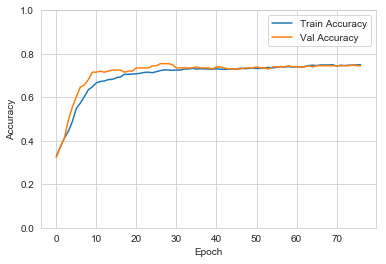

              precision    recall  f1-score   support

           0       0.91      0.73      0.81       233
           1       0.09      0.27      0.13        22

   micro avg       0.69      0.69      0.69       255
   macro avg       0.50      0.50      0.47       255
weighted avg       0.84      0.69      0.75       255

[[169  64]
 [ 16   6]]


In [197]:
model = create_smaller()
model.summary()
history = model.fit(X_train_scaled, y_train, epochs=EPOCHS*10,
                    validation_split = 0.2, verbose=0, batch_size=5, callbacks=[early_stop, PrintDot()])

plot_history(history)

pred = model.predict(X_test_scaled)
print(classification_report((pred > .5).astype(int),y_test))
print(confusion_matrix((pred > .5).astype(int),y_test))

### Repeat with Larger

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_32 (Dense)             (None, 4)                 32        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 5         
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________

..............................................................

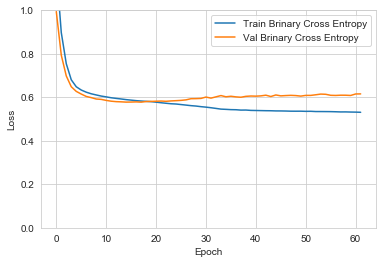

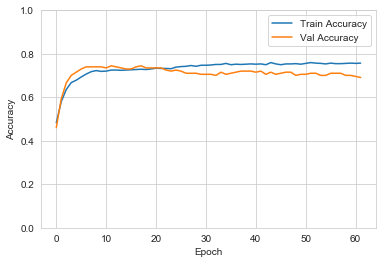

              precision    recall  f1-score   support

           0       0.93      0.75      0.83       228
           1       0.20      0.52      0.29        27

   micro avg       0.73      0.73      0.73       255
   macro avg       0.56      0.64      0.56       255
weighted avg       0.85      0.73      0.78       255

[[172  56]
 [ 13  14]]


In [198]:
model = create_larger()
model.summary()
history = model.fit(X_train_scaled, y_train, epochs=EPOCHS*10,
                    validation_split = 0.2, verbose=0, batch_size=5, callbacks=[early_stop, PrintDot()])

plot_history(history)

pred = model.predict(X_test_scaled)
print(classification_report((pred > .5).astype(int),y_test))
print(confusion_matrix((pred > .5).astype(int),y_test))

### Repeat with Defalut Plus

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________

.......................................................................................

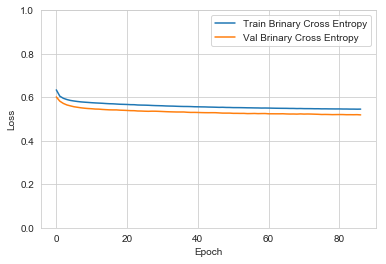

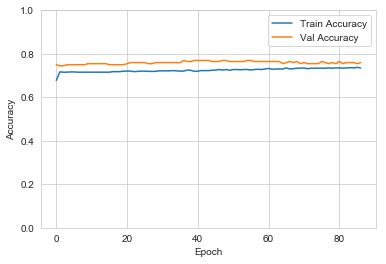

              precision    recall  f1-score   support

           0       0.97      0.75      0.84       240
           1       0.13      0.60      0.21        15

   micro avg       0.74      0.74      0.74       255
   macro avg       0.55      0.67      0.53       255
weighted avg       0.92      0.74      0.81       255

[[179  61]
 [  6   9]]


In [199]:
model = create_default_plus()
model.summary()
history = model.fit(X_train_scaled, y_train, epochs=EPOCHS*10,
                    validation_split = 0.2, verbose=0, batch_size=5, callbacks=[early_stop, PrintDot()])

plot_history(history)

pred = model.predict(X_test_scaled)
print(classification_report((pred > .5).astype(int),y_test))
print(confusion_matrix((pred > .5).astype(int),y_test))

## Looks like the more complex models did not help much...

Main objectives of above: 
1. Confirm the number of epochs needed to train. It seems 50 epochs is sufficient for all.
2. Coinfirm that our models do not suffer TOO much from the imbalanced classes.

I think we should use the 'micro' F1 score above, but could be convinced 'macro' is better...

[link to stack exchange discussion](https://datascience.stackexchange.com/questions/40900/whats-the-difference-between-sklearn-f1-score-micro-and-weighted-for-a-mult)

All models are around 70% by this metric.

#### OK, they do gain a few percentages but lets do a more robust estimation of the accuracy.

#### Let's make a Pipeline and use StratifiedKFold (10 splits) to do a more robust accuracy evaluation

In [200]:
X_train_full = Merged.drop(['weekend','date_np'],axis=1)
y_train_full = Merged['weekend'].astype(int)

In [201]:
from sklearn.pipeline import Pipeline
estimators = []
estimators.append(('quantile-ize', QuantileTransformer(output_distribution='normal')))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Standardized: 72.45% (2.31%)


In [202]:
estimators = []
estimators.append(('quantile-ize', QuantileTransformer(output_distribution='normal')))
estimators.append(('mlp', KerasClassifier(build_fn=create_smaller, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Standardized: 73.04% (1.60%)


In [203]:
estimators = []
estimators.append(('quantile-ize', QuantileTransformer(output_distribution='normal')))
estimators.append(('mlp', KerasClassifier(build_fn=create_larger, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Standardized: 72.65% (1.92%)


In [204]:
estimators = []
estimators.append(('quantile-ize', QuantileTransformer(output_distribution='normal')))
estimators.append(('mlp', KerasClassifier(build_fn=create_default_plus, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Standardized: 72.26% (1.20%)


### Lets stick with the Default, the other models do not seem to help much.

## Deliverables:
1. [Python Module](https://github.com/chmartin/FitBit-Analysis/blob/master/FitBit_Weeday_Classifier.py): Allows user to fit the NN to their own activity to make 'office day' vs 'recreation day' classification themselves using the 'defalut' NN.
2. [Tableau Dashboard](https://public.tableau.com/profile/christopher.martin1729#!/vizhome/FitBit-Analysis/Dashboard1): Take the output of the python module to make a nice visualization (below)

In [206]:
%%HTML

<center><iframe src="https://public.tableau.com/views/FitBit-Analysis/Dashboard1?:embed=y&:display_count=yes&:toolbar=no" width="1004" height="800" frameborder="0"></iframe></center>

## Next steps

My standard list of some ways that someone could make what I show here better.

1. Grid Search the NN space. I did not do a formal grid search of the hyperparameters but that would be a great next step to make the classification a little better.

2. Make a monthly analyzer, based on the classification make small script that outputs "X number of weekend days remaining" this month. The Tableau viz is nice, but not sure it actually provides something actionable yet.

3. Interface this with the FitBit API, to download and update model automatically and iteratively.

4. Downsampling the majority class, it could be that by downsampling the weekdays, upsampling the weekends, etc...

There are many other things, but those are three that I wanted to do. The reality is that I think with this simple model I have done extremely well with this dataset.

### Questions
* Have I missed something fundamental in my formulation of the problem? (_This will probably appear on most posts, I really wonder where I could do better!_)

* Is this applicable to other user's datasets? Any friends out there willing to let me play with their FitBit data? I want to know if this is too specific to me!

* Can this technique be generalized? E.g. athletes on a training schedule. Can this be used to tell them that they need more rest/recovery days? What about people with more active hobbies (e.g. hiking) than myself? I imagine it would do even better classification in those cases!